# get alphas & generate new configs

In [1]:
# get alphas
import os
import collections
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

global_threshold = 0

def gen_new_config(data: dict, avg=False):
    global global_threshold
    new_structure_configs = [{}, {}]
    min_alpha = float('inf')
    total_param = 0
    for name, v in data.items():
        # selected modeules
        if v[1] == True:
            total_param += v[2]
            if v[0] < min_alpha:
                min_alpha = v[0]

            names = [item.strip() for item in name.split('|')]

            new_structure_config = new_structure_configs[1 if (names[0].endswith(
                'SelfAttention') or names[0].endswith('DenseReluDense')) else 0]
                
            param_name = new_structure_config.get(names[0], {})
            new_structure_config[names[0]] = param_name
            insert_method = param_name.get(names[1], {})
            param_name[names[1]] = insert_method
            insert_method[names[2]] = {
                "lora_r": 1} if names[2] == 'Lora' else {}
    if avg:
        print('threshold: ',min_alpha)
        global_threshold = min_alpha

    return new_structure_configs


def plot_p_together_and_gen_config(root_path, seed_list, datasets, max_param=0, top=10):
    datas = {}
    total_data = defaultdict(list)
    num_param_dict = {}
    for dataset in datasets:
        for seed in seed_list:
            data = {}
            # read final_alphas of every seed
            path = os.path.join(root_path, dataset,
                                str(seed), "final_alphas.txt")
            try:
                with open(path, 'r') as f:
                    for l in f:
                        if '.' in l:
                            splited_a = l.split('|')[1:]
                            name = '|'.join(splited_a[0:3])  # get key

                            # set value (for avg)
                            total_data[name].append(
                                float(splited_a[5].strip()))
                            data[name] = [float(splited_a[5].strip()), False, float(
                                splited_a[3].strip())]  # set value

                            num_param_dict[name] = float(
                                splited_a[3].strip())  # get num of param

                datas[str(dataset)+str(seed)] = data
                print("successed: ", path)
            except:
                print(f"not found: {path}")
    # calculate avg
    avg = {}
    for k, v in total_data.items():
        avg[k] = [np.mean(v), False, num_param_dict[k]]

    datas['avg'] = avg

    # get final structure
    for seed in datas:
        data = datas[seed]
        all_modules = []
        for k, v in data.items():
            all_modules.append([k, v[2], v[0]])  # (name,num_param,p)
        all_modules.sort(key=lambda x: x[2], reverse=True)

        total_params = 0
        for idx, module_param in enumerate(all_modules):
            if total_params+module_param[1] <= max_param:
                # chose
                data[module_param[0]][1] = True
                total_params += module_param[1]

    # gen new config
    new_structure_configs = {}
    for seed in datas:
        if seed != 'total':
            new_structure_configs[seed] = gen_new_config(
                datas[seed], seed == 'avg')
    datas['total'] = total_data
    return datas, new_structure_configs


# get heatmap

In [2]:
# get heatmap
import pandas as pd

# columns_uni = ['E.0', 'E.1', 'E.2', 'E.3', 'E.4', 'E.5', 'E.6', 'E.7', 'E.8', 'E.9', 'E.10', 'E.11', 'E.12', 'E.13', 'E.14', 'E.15', 'E.16', 'E.17', 'E.18', 'E.19', 'E.20', 'E.21', 'E.22', 'E.23',
#                'E', 'D.0', 'D.1', 'D.2', 'D.3', 'D.4', 'D.5', 'D.6', 'D.7', 'D.8', 'D.9', 'D.10', 'D.11', 'D.12', 'D.13', 'D.14', 'D.15', 'D.16', 'D.17', 'D.18', 'D.19', 'D.20', 'D.21', 'D.22', 'D.23', 'D']
# rows_uni = ['q.Lora', 'k.Lora', 'v.Lora', 'o.Lora', 'wi.Lora', 'wo.Lora',
#             'SA.LRA', 'DRD.LRA',
#             'SA.LN.BitFit', 'q.BitFit',  'k.BitFit',  'v.BitFit',  'o.BitFit',  'CSA.LN.BitFit', 'DRD.LN.BitFit', 'wi.BitFit', 'wo.BitFit', 'final_LN.BitFit',
#             'SA.LN.LNFit', 'CSA.LN.LNFit', 'DRD.LN.LNFit', 'final_LN.LNFit',
#             ]

def get_heatmap(datas, dataset, root_path,rows_uni,columns_uni, type='count', seed=0):
    df = pd.DataFrame(np.zeros((len(rows_uni), len(columns_uni))),
                      index=rows_uni, columns=columns_uni)
    columns = []
    rows = []

    def add(data):
        for k, v in data.items():
            names = [i.strip() for i in k.split('|')]
            column = names[0].split('.')[slice(0, 3, 2)]

            column = column[0].replace('encoder', "E").replace(
                'decoder', 'D') + ('.23' if len(column) == 1 else ('.'+column[1]))
            columns.append(column)

            row = names[0].split('.')[-1]
            if row == 'layer_norm':
                tmp = names[0].split('.')
                if tmp[-2] == '0':
                    row = "SA.layer_norm"
                else:
                    if tmp[0] == 'decoder' and tmp[-2] == '2':
                        row = "DRD.layer_norm"
                    elif tmp[0] == 'decoder' and tmp[-2] == '1':
                        row = "CSA.layer_norm"

                    elif tmp[0] == 'encoder' and tmp[-2] == '1':
                        row = "DRD.layer_norm"
                    else:
                        print(names)
                        raise NotImplementedError
            row = row+'.'+names[2].replace('BitFitParallel', 'BitFit')
            row = row.replace("layer_norm", 'LN').replace("LowRankAdapter", 'LRA').replace(
                "SelfAttention", 'SA').replace("DenseReluDense", 'DRD')
            rows.append(row)
            if type == 'p':
                if df.loc[row,column] == 0:
                    df.loc[row,column] = v[0]
                else:
                    raise NotImplementedError
            elif type == 'count':
                df.loc[row,column] += int(v[1])

    if type == 'p':
        print(seed)
        add(datas[seed])
    elif type == 'count':
        if seed is None:
            for seed, d in datas.items():
                if seed != 'avg' and seed != 'total':
                    print(seed)
                    add(d)
        else:
            print(seed)
            add(datas[seed])

    columns_uni_ = list(set(columns))
    columns_uni_.sort(key=columns.index)
    print(columns_uni_)
    rows_uni_ = list(set(rows))
    rows_uni_.sort(key=rows.index)
    print(rows_uni_)

    df.drop(list(set(rows_uni)-set(rows_uni_)),axis=0,inplace = True)
    df.drop(list(set(columns_uni)-set(columns_uni_)),axis=1,inplace = True)

    df_values = df.values
    # df_values[df_values==0]=-(df_values.max()-df_values.min())/20


    
    columns_uni_.sort(key=columns_uni.index)
    rows_uni_.sort(key=rows_uni.index)
    columns_uni=columns_uni_
    rows_uni=rows_uni_



    return df_values
    # print(data)


# plot heatmap

In [3]:
# plot heatmap
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import matplotlib
import  matplotlib.pyplot as plt

def f_alpha(x):
    return x

def f_alpha_1(x):
    return x

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    """

    if not ax:
        ax = plt.gca()

    im = ax.imshow(data, **kwargs)
    
    formatter = matplotlib.ticker.StrMethodFormatter('{x:.1f}')
    cax = ax.figure.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax,format=formatter,**cbar_kw)
    cbar.formatter = formatter
    cbar.minorticks_on()
    cbar.update_ticks()
    # cbar=None

    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom",fontsize=18)
    print(cbar.get_ticks())
    cbar.set_ticks(cbar.get_ticks()[:-1])
    cbar.set_ticklabels([f'{i:.1f}' for i in f_alpha_1(cbar.get_ticks())[:]])
    cbar.ax.tick_params(axis='y', labelsize=18)


    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(col_labels,fontsize=17)
    ax.set_yticklabels(row_labels,fontsize=17)


    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)


    plt.setp(ax.get_xticklabels(), rotation=-61.8, ha="left",
             rotation_mode="anchor")


    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)

    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)

    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],textalphas=[1,0],
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    if threshold is not None:
        threshold = threshold
    else:
        threshold = data.max()
    print(threshold)

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(data[i, j] >= threshold)],alpha=textalphas[int(data[i, j] >= threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_heatmap(df_values,rows_uni,plot_rows_uni,columns_uni,threshold,save_name):
    fig, ax = plt.subplots()

    fig.set_figheight(10/1.2)
    fig.set_figwidth(25/1.2)
    fig.set_dpi(400)

    im, cbar = heatmap(f_alpha(df_values), plot_rows_uni, columns_uni, ax=ax,
                    cmap="Greens", cbarlabel="$p_i$")

    texts = annotate_heatmap(im,df_values, valfmt="{x:.2f}",threshold=threshold,textcolors=["white","white"],textalphas=[0,1],fontsize=9)

    # fig.tight_layout()  
    print(save_name)
    plt.savefig(save_name)
    plt.show()      

specify params here

In [4]:
backbone_params = 703.4677734375
sparse_rate_relative = 0.0000348

root_path = "output/example"
seed_list = [100]
#[100,101,102,103,104]

datasets = ['superglue-cb']

save_name = f'example_superglue-cb_heatmap.png'

successed:  output/example/superglue-cb/100/final_alphas.txt
threshold:  0.13064
avg
['E.0', 'E.1', 'E.2', 'E.3', 'E.4', 'E.5', 'E.6', 'E.7', 'E.8', 'E.9', 'E.10', 'E.11', 'E.12', 'E.13', 'E.14', 'E.15', 'E.16', 'E.17', 'E.18', 'E.19', 'E.20', 'E.21', 'E.22', 'E.23', 'D.0', 'D.1', 'D.2', 'D.3', 'D.4', 'D.5', 'D.6', 'D.7', 'D.8', 'D.9', 'D.10', 'D.11', 'D.12', 'D.13', 'D.14', 'D.15', 'D.16', 'D.17', 'D.18', 'D.19', 'D.20', 'D.21', 'D.22', 'D.23']
['q.Lora', 'q.BitFit', 'k.Lora', 'k.BitFit', 'v.Lora', 'v.BitFit', 'o.Lora', 'o.BitFit', 'SA.LN.LNFit', 'SA.LN.BitFit', 'wi.Lora', 'wi.BitFit', 'wo.Lora', 'wo.BitFit', 'DRD.LN.LNFit', 'DRD.LN.BitFit', 'final_LN.LNFit', 'final_LN.BitFit', 'CSA.LN.LNFit', 'CSA.LN.BitFit', 'SA.LRA', 'DRD.LRA']
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16]
0.13064
example_superglue-cb_heatmap.pdf


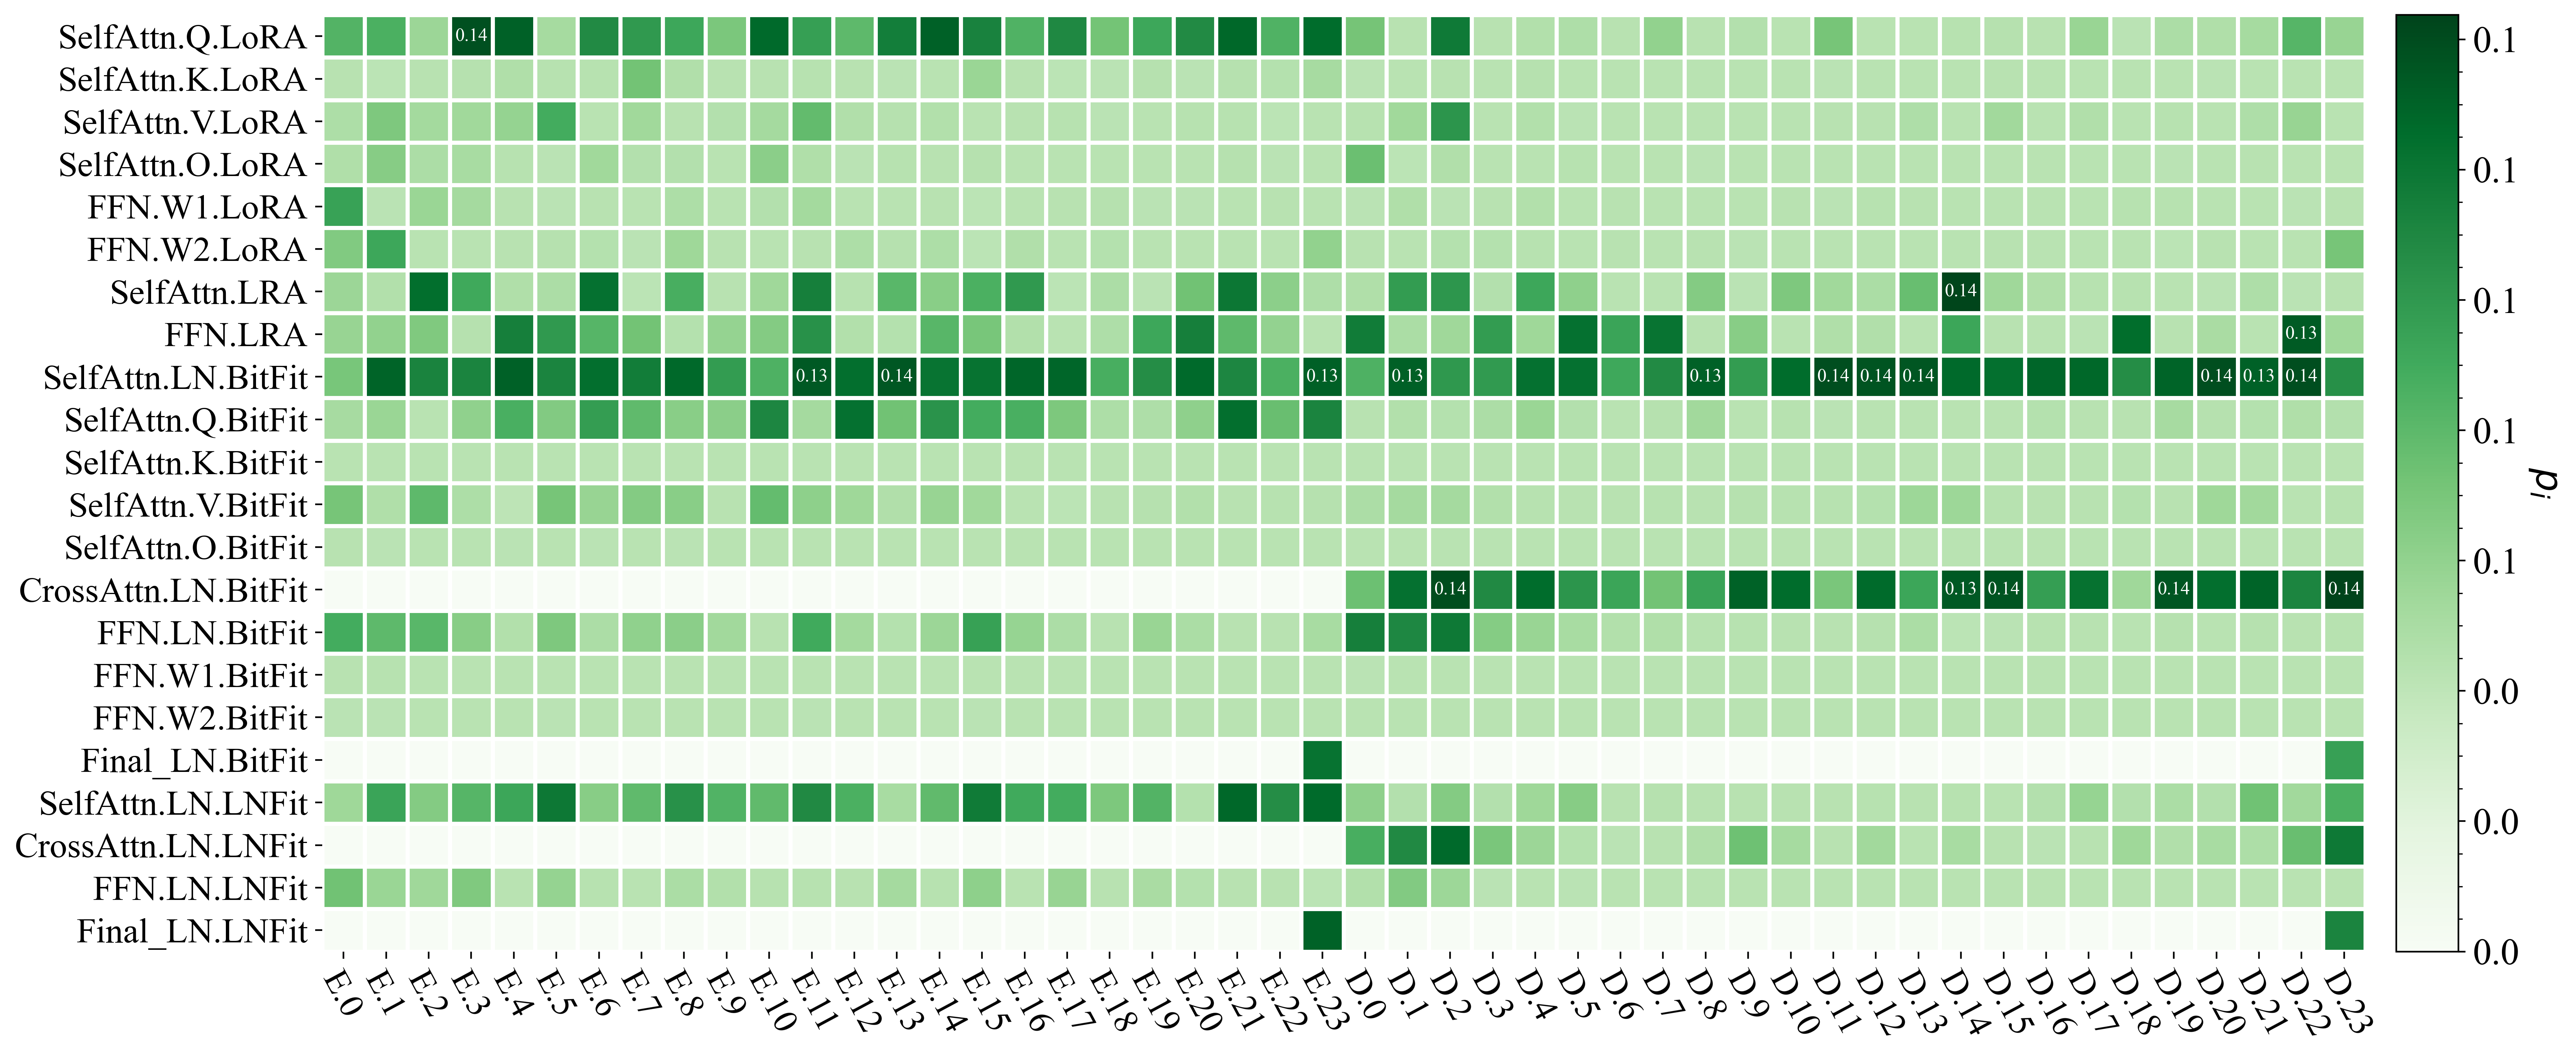

In [5]:
columns_uni = ['E.0', 'E.1', 'E.2', 'E.3', 'E.4', 'E.5', 'E.6', 'E.7', 'E.8', 'E.9', 'E.10', 'E.11', 'E.12', 'E.13', 'E.14', 'E.15', 'E.16', 'E.17', 'E.18', 'E.19', 'E.20', 'E.21', 'E.22', 'E.23',
               'D.0', 'D.1', 'D.2', 'D.3', 'D.4', 'D.5', 'D.6', 'D.7', 'D.8', 'D.9', 'D.10', 'D.11', 'D.12', 'D.13', 'D.14', 'D.15', 'D.16', 'D.17', 'D.18', 'D.19', 'D.20', 'D.21', 'D.22', 'D.23']

rows_uni = ['q.Lora', 'k.Lora', 'v.Lora', 'o.Lora', 'wi.Lora', 'wo.Lora',
            'SA.LRA', 'DRD.LRA',
            'SA.LN.BitFit', 'q.BitFit',  'k.BitFit',  'v.BitFit',  'o.BitFit',  'CSA.LN.BitFit', 'DRD.LN.BitFit', 'wi.BitFit', 'wo.BitFit', 'final_LN.BitFit',
            'SA.LN.LNFit', 'CSA.LN.LNFit', 'DRD.LN.LNFit', 'final_LN.LNFit',
            ]

datas, new_structure_configs = plot_p_together_and_gen_config(
    root_path, seed_list, datasets, backbone_params*sparse_rate_relative)

plot_rows_uni = ['SelfAttn.Q.LoRA', 'SelfAttn.K.LoRA', 'SelfAttn.V.LoRA', 'SelfAttn.O.LoRA', 'FFN.W1.LoRA', 'FFN.W2.LoRA',
                 'SelfAttn.LRA', 'FFN.LRA',
                 'SelfAttn.LN.BitFit', 'SelfAttn.Q.BitFit',  'SelfAttn.K.BitFit',  'SelfAttn.V.BitFit',  'SelfAttn.O.BitFit',  'CrossAttn.LN.BitFit', 'FFN.LN.BitFit', 'FFN.W1.BitFit', 'FFN.W2.BitFit', 'Final_LN.BitFit',
                 'SelfAttn.LN.LNFit', 'CrossAttn.LN.LNFit', 'FFN.LN.LNFit', 'Final_LN.LNFit',
                 ]
# plot_rows_uni = ['SelfAttn.Q.LoRA', 'SelfAttn.K.LoRA', 'SelfAttn.V.LoRA', 'SelfAttn.O.LoRA', 'FFN.W1.LoRA', 'FFN.W2.LoRA']
if not os.path.exists('./fig/'):
    os.makedirs('./fig')
plot_heatmap(get_heatmap(datas, datasets, root_path, rows_uni, columns_uni, type='p', seed='avg'),
             rows_uni, plot_rows_uni, columns_uni, global_threshold, os.path.join('./fig',save_name))
